# WESAD Dataset Creation
In this notebook, we create TS from the WESAD data archive.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle, gzip

sns.set_theme()
sns.set_color_codes()

import Orange
import os
import sys
sys.path.append("../../")

from tqdm import tqdm
from src.visualizer import plot_ts

First, we need to download the mHealth data archive from https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/ and place it into the DATA_PATH folder.

In [3]:
DATA_PATH = "../../archives/WESAD/"

Now, we define a helper procedure to extract change points from a series of activities.

In [4]:
def extract_cps(activities):
    cps = list()

    for idx in range(1, len(activities)):
        if activities[idx-1] != activities[idx]:
            cps.append(idx)

    return np.array(cps, dtype=np.int64)

Let's write the function to load the request time series with annotated change points.

In [5]:
def load_wesad_ts(subject, mode="chest", resample_rate=1):
    with open(DATA_PATH + f"S{subject}/S{subject}.pkl", 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data = u.load()
        
    labels = data["label"]
    valid_mask = np.isin(labels, [1,2,3,4])
    
    cps = extract_cps(labels[valid_mask])
    df = []
    
    for sensor in ('ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'): # 
        if sensor == "ACC":
            for idx, ax in enumerate("XYZ"):
                ts = data["signal"][mode][sensor][:,idx][valid_mask].reshape(-1,1)
                name = f"WESAD Subject{subject} {mode} {ax}-{sensor}"
                df.append((name.replace(" ", "_"), cps, ts))
        else:
            name = f"WESAD Subject{subject} {mode} {sensor}"
            ts = data["signal"][mode][sensor][valid_mask].reshape(-1,1)
            df.append((name.replace(" ", "_"), cps, ts))

    return pd.DataFrame.from_records(df, columns=["name", "change_points", "time_series"])

Now, let's load the subject data and explore it.

In [6]:
df = load_wesad_ts(2, "chest")

<Figure size 432x288 with 0 Axes>

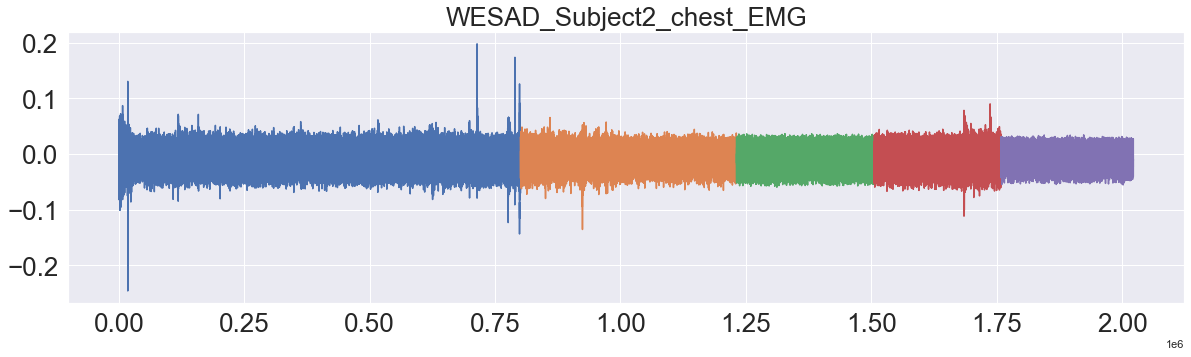

In [7]:
selection = 4

name, cps, ts = df.iloc[selection, :].tolist()

plot_ts(
    name,
    ts,
    cps,
    show=True
)

Finally, let's save the TS dataset.

In [8]:
DATASET_PATH = "../../datasets/WESAD/"

In [9]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [10]:
desc = []
data = dict()
window_size = 700

for subject in np.arange(2,6):
    df = load_wesad_ts(subject, "chest")

    for _, (name, cps, ts) in df.iterrows():
        desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
        data[name] = ts
            
np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)